<center>
<h1> </h1>
<h1>Analysis of Factors Impacting Democracies</h1>
<h5>Spring 2024 Data Science Project</h5>
<h7> By Leemah Bisht
</center>


---











<h2> Introduction </h2>

Government transitions are pivotal events that can significantly impact a country. Understanding the factors influencing these transitions is crucial for policymakers, researchers, and citizens. In this project, we leverage data science techniques to investigate the relationship between economic and social factors and government transitions.

The primary research questions (i.e. hypothesis) guiding us:

1. Are economic and social factors combined good indicators of government transitions?
2. How do different dependent variables correlate with government transitions and types?

In this tutorial I will walk you through the entire data science pipeline: acquiring and curating data, parsing the data into a queryable format, exploratory data analysis, machine learning, and explaining the results with words and visualizations.

This project was completed by Leemah Bisht.


##Part 0: Importing libraries

Before we begin on the data pipeline, we need to import the necessary libraries needed for the code in this notebook.

In [35]:
#importing the libraries
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import random
import seaborn as sns
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Part 1: Data Collection

######Data Sources


1. **The Episodes of Regime Transformation (ERT) dataset**: Identifies episodes of democratization (liberalizing autocracy, democratic deepening) and autocratization (democratic regression,autocratic regression) in the most recent V-Dem dataset.
*  Src: https://github.com/vdeminstitute/ERT/blob/master/inst/ert.csv

2. **World Bank Development Indicators**: Data about World Development Indicators measured from 1960 to 2022, extracted from the World Bank database. It includes macro- economic, social, political, and environmental data from all the countries and regions the world bank has data about.
*  Src: https://www.kaggle.com/datasets/nicolasgonzalezmunoz/world-bank-world-development-indicators




In [36]:
#importing the datasets
ert_df = pd.read_csv("/content/drive/MyDrive/cmsc320/final-project/ert_dataset.csv") # The Episodes of Regime Transformation (ERT) dataset:
wrld_bnk = pd.read_csv("/content/drive/MyDrive/cmsc320/final-project/world_bank_development_indicators.csv") #World Bank Development Indicators

##Part 2: Data Cleaning

####Selected Features for Analysis
For our analysis on government transitions, based on my domain knowledge I have selected key features from the datasets (ert_df and wrld_bnk) after refering to their relevance to understanding socio-economic conditions.

**From `ert_df` (Political Regime Transitions Data):**
- `reg_trans`: Indicates the nature of governance transition in the country-year:
  - `-1`: Democratic breakdown (shift away from democracy).
  - `0`: No regime transition.
  - `1`: Democratic transition (move towards democracy).
- `reg_type`: Classifies the type of governance as either autocracy (`0`) or democracy (`1`).

**From `wrld_bnk` (World Bank Economic Indicators Data):**
- `trade_in_services%`: Percentage of GDP attributed to trade in services, reflecting economic openness.
- `inflation_annual%`: Annual inflation rate percentage, a measure of economic stability.
- `military_expenditure%`: Percentage of GDP allocated to military spending, indicating national security priorities.
- `GDP_current_US`: Gross Domestic Product (GDP) in current US dollars, reflecting economic size.
- `government_expenditure_on_education%`: Percentage of government budget allocated to education, highlighting investment in the citizens.
- `government_health_expenditure%`: Percentage of government budget allocated to healthcare, reflecting general access to healthcare.


In [37]:
ert_df_filtered = ert_df[['country_name', 'year', 'reg_trans', 'reg_type']]

wrld_bnk_filtered = wrld_bnk[['country', 'date', 'trade_in_services%', 'inflation_annual%', 'military_expenditure%', 'GDP_current_US', 'government_expenditure_on_education%', 'government_health_expenditure%']]

####Formatting the Dataframes
Renaming columns to more human readable names and transforming date-related data into a more usable format for analysis.

In [38]:
#renaming the coloumns
ert_df_filtered = ert_df_filtered.rename(columns={"country_name": "country", "reg_trans": "transition", "reg_type": "governance_type"})

wrld_bnk_filtered = wrld_bnk_filtered.rename(columns={"trade_in_services%": "services_trade", "inflation_annual%": "inflation_annual", "military_expenditure%": "military_expenditure", "government_expenditure_on_education%": "government_expenditure_on_education", "government_health_expenditure%":"government_health_expenditure"})

#converting the dates to only year based
wrld_bnk_filtered['date'] = pd.to_datetime(wrld_bnk_filtered['date'])
wrld_bnk_filtered['year'] = wrld_bnk_filtered['date'].dt.year

wrld_bnk_filtered.drop(columns=['date'], inplace=True) #dropping the old date column

####Aligning the Timeframes

Need to make sure that both the datasets have the corresponding years.
1. Find out what is the min & max years for both datasets.
2. Filter the dataframes to have minimum 30 years in common.

In [39]:
# For Episodes of Regime Transformation (ERT) dataset
ert_min = ert_df_filtered['year'].min()
ert_max = ert_df_filtered['year'].max()
print(f"ERT data range: {ert_min}-{ert_max}")

# For World Bank Development Indicators dataset
wrld_bnk_min = wrld_bnk_filtered['year'].min()
wrld_bnk_max = wrld_bnk_filtered['year'].max()
print(f"World Bank data range: {wrld_bnk_min}-{wrld_bnk_max}")

ERT data range: 1900-2022
World Bank data range: 1960-2022


In [40]:
# Filtered ERT Dataset for years 1990-2022
ert_filtered_df = ert_df_filtered[(ert_df_filtered['year'] >= 1990) & (ert_df_filtered['year'] <= 2022)]

# Filtered World Bank Development Indicators Dataset for years 1990-2022
wrld_filtered_df = wrld_bnk_filtered[(wrld_bnk_filtered['year'] >= 1990) & (wrld_bnk_filtered['year'] <= 2022)]

####Merging all DataFrames

Now that we have completed the formatting, we can merge the two dataframes on common country & year.

In [41]:
df = pd.merge(ert_filtered_df, wrld_filtered_df, on=['country', 'year'], how='inner')
df.head(5)

,country,year,transition,governance_type,services_trade,inflation_annual,military_expenditure,GDP_current_US,government_expenditure_on_education,government_health_expenditure
0,Mexico,1990,0.0,0.0,8.409069,26.651673,0.433081,2.612537e+11,2.32498,NaN
1,Mexico,1991,0.0,0.0,7.625352,22.662359,0.435402,3.131397e+11,2.54800,NaN
2,Mexico,1992,0.0,0.0,7.153089,15.507896,0.469455,3.631578e+11,3.00502,NaN
3,Mexico,1993,0.0,0.0,5.387098,9.751460,0.442785,5.007334e+11,NaN,NaN
4,Mexico,1994,0.0,0.0,5.526020,6.965812,0.518830,5.278106e+11,3.64709,NaN


####Fixing the Missing Data (if any)

**Assessing the Extent of Missingness**

In [42]:
print(f"Total number of rows: {len(df)}")
print(f"Number of rows with missing data: {len(df[df.isnull().any(axis=1)])}")

Total number of rows: 5051
Number of rows with missing data: 3006


As seen above, 3006 out of the 5051 rows contain at least one missing value. This is very not ideal. After examining dataset, I can identify that the main cause for missing data is that data is actually unavailable, especially for countries not from the developed world.

To address, I will be performing **K-nearest Neighbors (KNN) Imputation**: Use the values of nearest neighbors to estimate missing values.

**K-nearest Neighbors (KNN) Imputation**


*Prerequisite: Remove non-numerical data to perform the imputatuon.*

In [43]:
df_var = df
df_var.drop(columns=['country'], inplace=True)
df_var.drop(columns=['year'], inplace=True)

*Perform the imputation.*

In [44]:
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_var), columns=df_var.columns)

**Evaluating the Imputed Data**

Questions to address:
1. Are there any null values remaining?
2. How did the imputed data impact key statistics of the features?

In [45]:
# Check for remaining missing values
remaining = df_imputed.isnull().sum()
print(f"What are the remaining null values:")
print(remaining)

What are the remaining null values:
transition                             0
governance_type                        0
services_trade                         0
inflation_annual                       0
military_expenditure                   0
GDP_current_US                         0
government_expenditure_on_education    0
government_health_expenditure          0
dtype: int64


In [46]:
#comparison between pre & post imputed dataset
orignal = df_var.describe()
imputed = df_imputed.describe()

key_metrics = ['mean', 'min', 'max']
comparison_stats = pd.DataFrame(index=key_metrics, columns=df_var.columns)

for col in df_var.columns:
    for metric in key_metrics:
        original_val = orignal.loc[metric, col]
        imputed_val = imputed.loc[metric, col]
        comparison_stats.loc[metric, col] = imputed_val - original_val

print("Comparison of Key Statistics (Imputed - Original):")
print(comparison_stats)

Comparison of Key Statistics (Imputed - Original):
     transition governance_type services_trade inflation_annual  \
mean   0.000011       -0.000011       1.738097        13.440294   
min         0.0             0.0            0.0              0.0   
max         0.0             0.0            0.0              0.0   

     military_expenditure    GDP_current_US  \
mean             0.860125 -770678872.899231   
min                   0.0               0.0   
max                   0.0               0.0   

     government_expenditure_on_education government_health_expenditure  
mean                           -0.108129                     -0.841124  
min                                  0.0                           0.0  
max                                  0.0                           0.0  


**Conclusion of pre & post imputation:**

* There are no more null values in the dataset.
*   The min and max values remain unchanged (0.0), suggesting that imputation did not introduce new extreme values for these columns.
*   With reference to my domain knowledge, the impact of the imupation for the various variables while notable, is not a significant problem.



##Part 3: Data Exploration

For exploring the data, I have two main intentions:
1. **Exploring Data Distribution:** Box plots and distribution graphs provide insights into the spread, central tendency, and shape of the data.
2. **Understadning Relationships between factors:** The correlation matrix reveals how variables are related to each other, highlighting potential dependencies.

*Note: This section is slightly different from my checkoff 2, to better suit the contonuity of this tutorial.*

###Box Plot (Box & Whisker Plot)

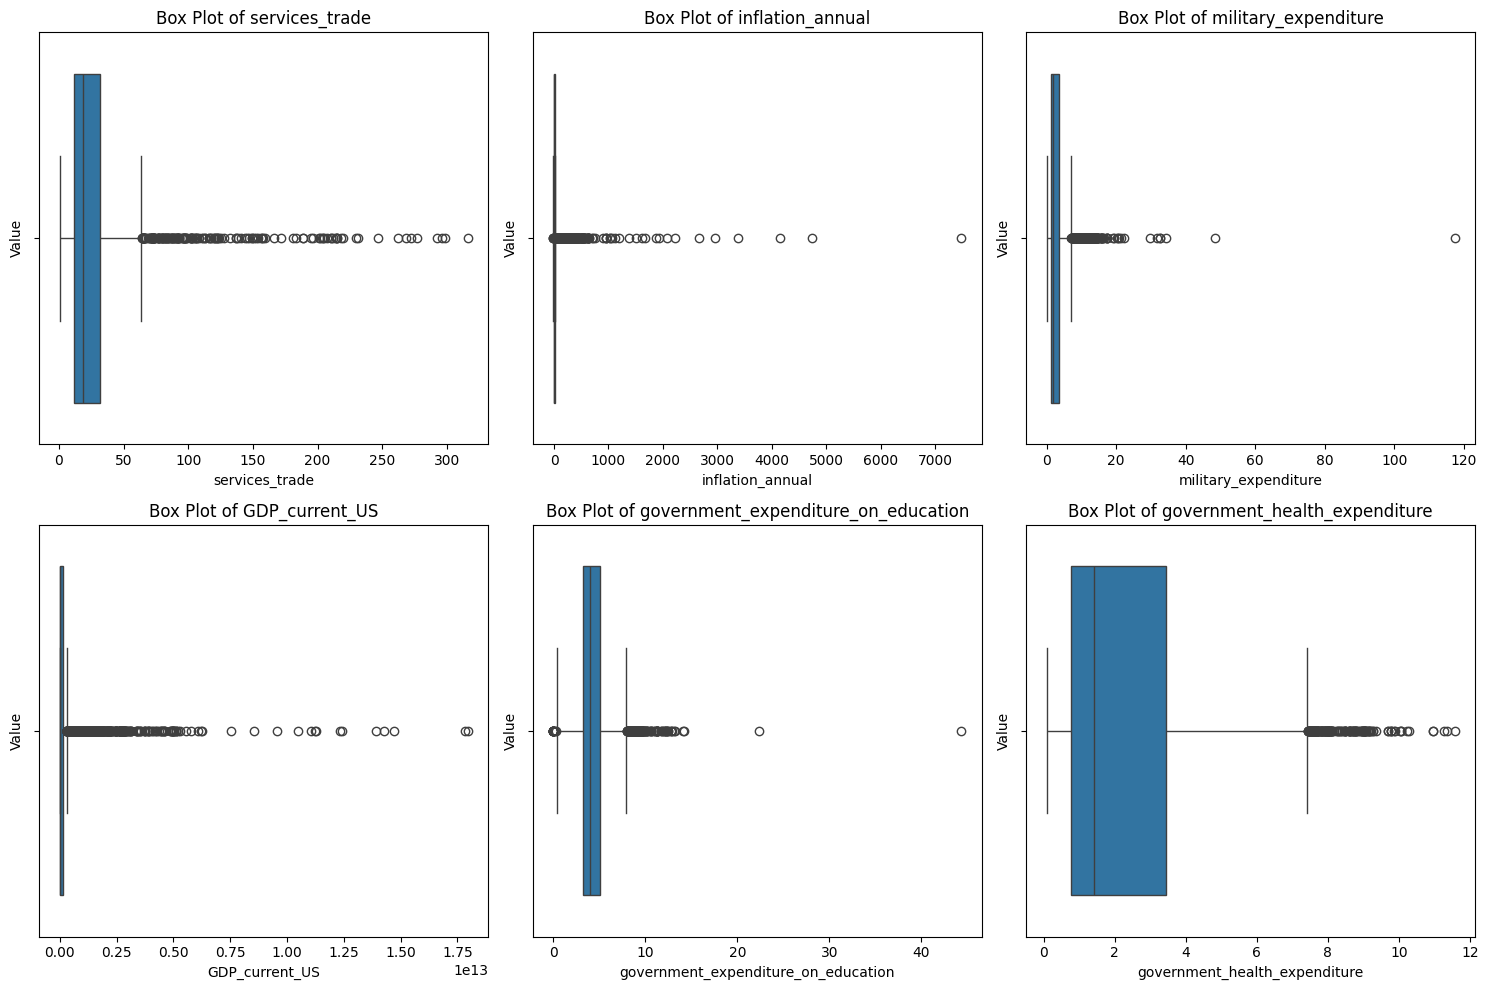

In [47]:
dependent_features = ['services_trade', 'inflation_annual', 'military_expenditure',
                      'GDP_current_US', 'government_expenditure_on_education', 'government_health_expenditure']

# Create individual box plots for each dependent feature
plt.figure(figsize=(15, 10))

for i, feature in enumerate(dependent_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df_imputed[feature])
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Value')

plt.tight_layout()  # Adjusting the subplot layout for better spacing
plt.show()

###Distribution Graph

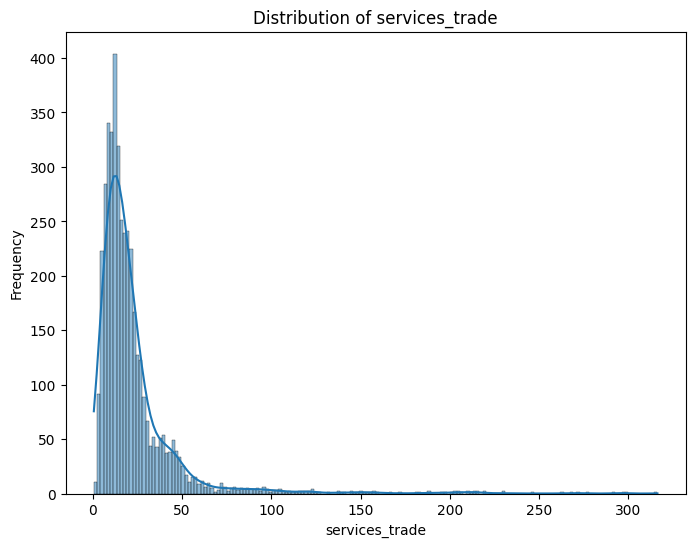

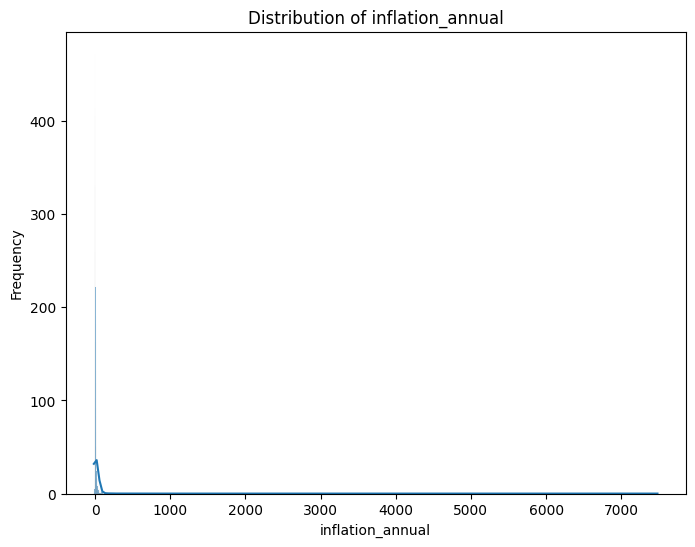

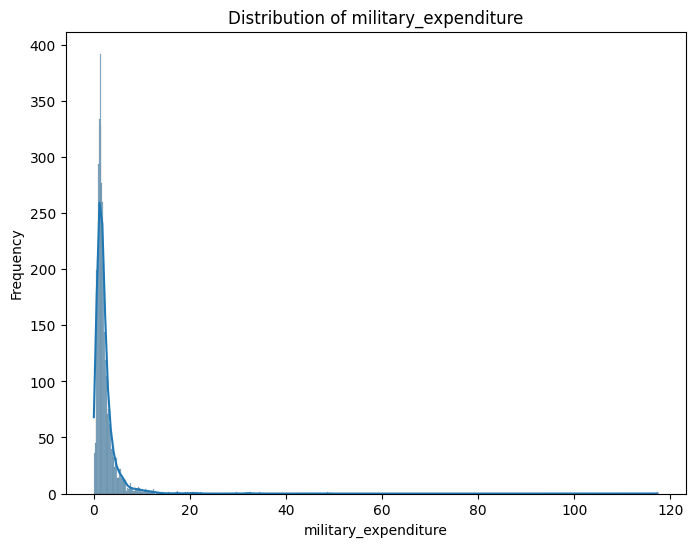

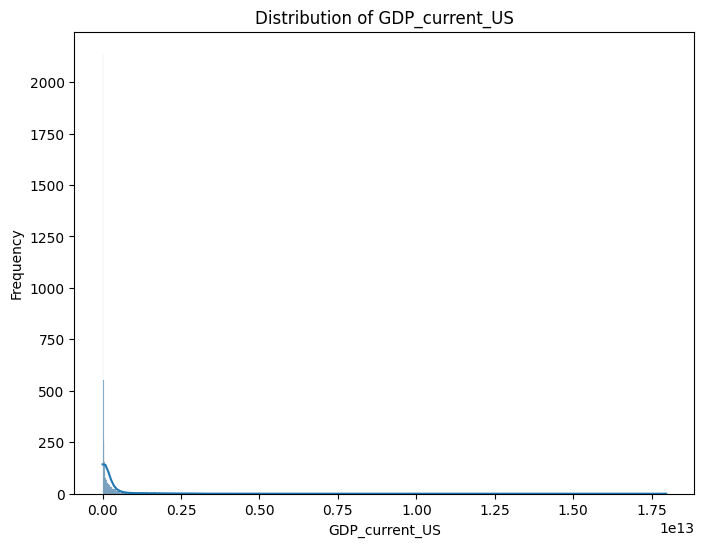

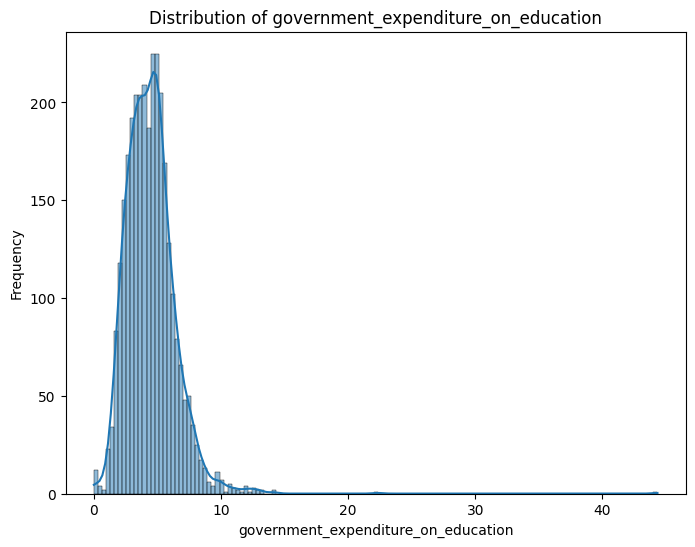

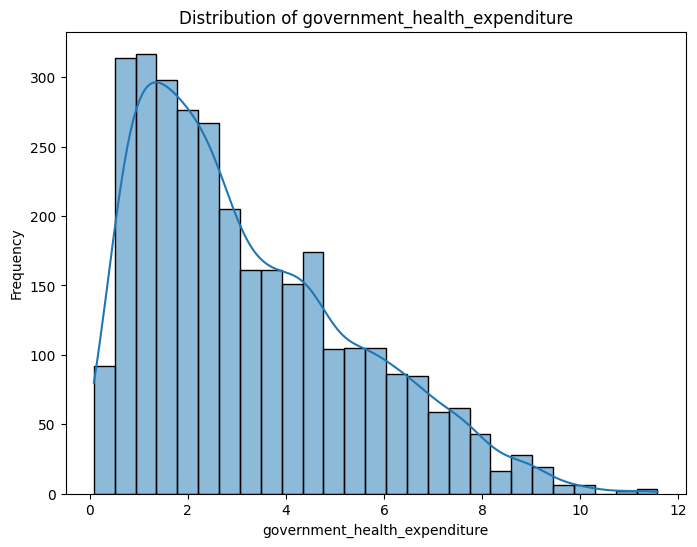

In [48]:
for col in df_imputed.columns[2:]: #excluding transition and governemnt type from plot
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

###Correlation Matrix

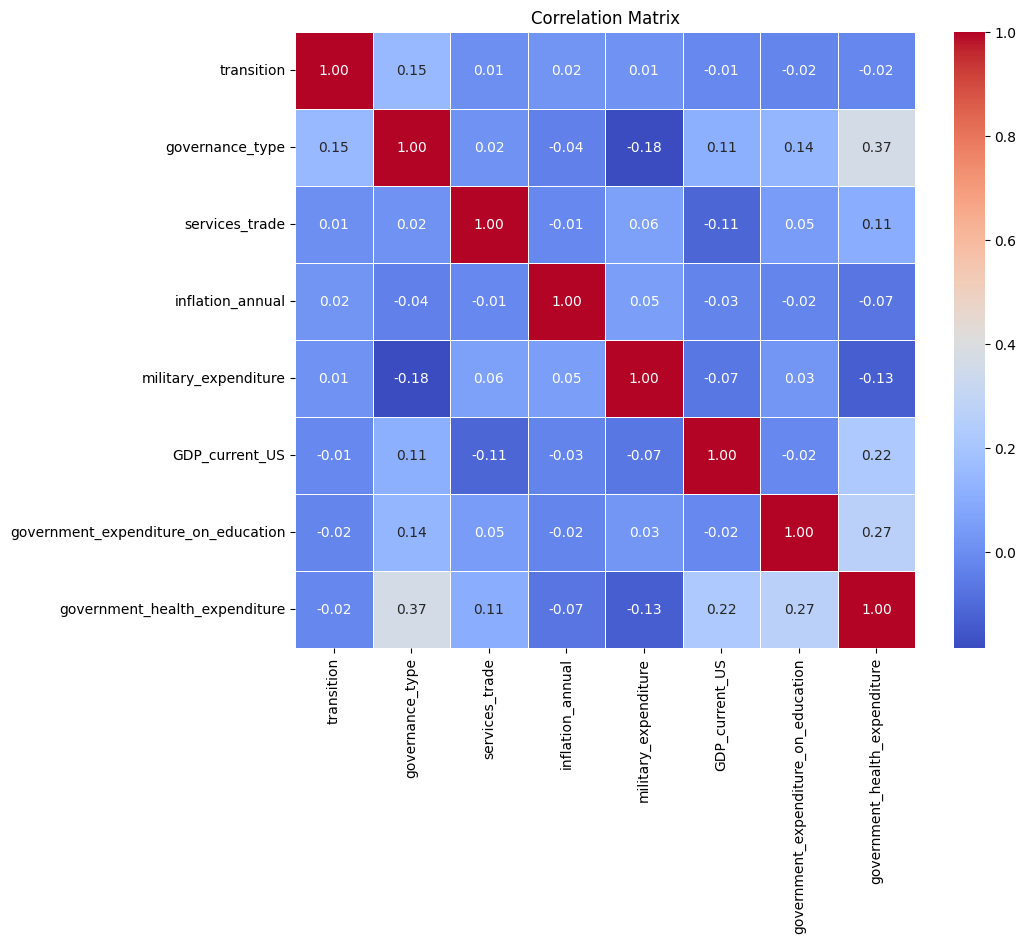

In [49]:
# Calculate correlation matrix
correlation_matrix = df_imputed.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

###Insights from the Data Exploration:


*   There are extreme outliers for some features (infaltion_rate, military_exxpenditure and governemnt_expenditure_on_education).
* Most of the features have a right-skewed distribution, with the exception of government_health_expenditure.
* None of the features are strongly correlated to each other, with all having correlation corfficients between -0.3 and 0.3.



##Part 4: Primary Analysis

###Random Forest Classifier for Governemnt Transition Prediction
The Random Forest Classifier was selected for the following reasons:
1. **Handling non-linear relationships:** Government transition prediction often involves complex and non-linear relationships between predictor variables (e.g., GDP, military expenditure, inflation) and the target variable (government transition type).
2. **Feature Importance Estimation:** Random Forests provide a method for assessing the importance of different features in predicting government transitions. It automatically takes those into account.

**Converting Continuous 'Transition' var into Categorical Classes**

The original transition variable in our dataset represented government transitions with float datatypes, I have mapped them to 3 classes respectively:
  - -1: Democratic breakdown (indicating a shift away from democracy).
  - 0: No transition (indicating no regime change).
  - 1: Democratic transition (indicating a move towards democracy).

In [50]:
# Convert continuous target variable to categorical labels
df_imputed['transition'] = df_imputed['transition'].astype(int)  # Convert to integer type if needed

# Map continuous values to categorical labels
df_imputed['transition'] = df_imputed['transition'].map({-1: 'Democratic breakdown', 0: 'No transition', 1: 'Democratic transition'})


**Splitting the Training & Test Data**

In [51]:
X = df_imputed.drop(['transition'], axis=1)  # All features excluding 'transition'
y = df_imputed['transition']  # Target variable 'transition'

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Standardising the Features**

In [52]:
# Define preprocessing steps for numerical and categorical features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardize numeric features
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])


**Combine preprocessing with the classifier in a pipeline**

In [53]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42))])

**Fitting the model & making predictions**

In [54]:
pipeline.fit(X_train, y_train) #fitting

y_pred = pipeline.predict(X_test) #predictions

##Part 5: Visualization

###Evaluating the Model Performance

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9812067260138477
Precision: 0.9696908266494305
Recall: 0.9812067260138477
F1-score: 0.9726686277698605


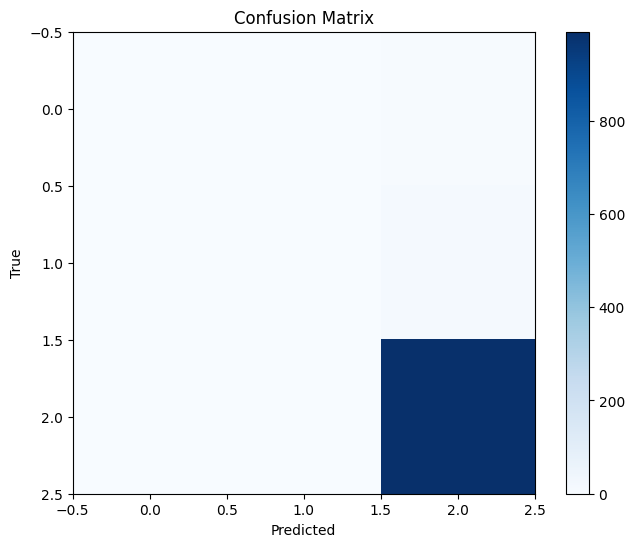

In [55]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

####Analysis of results:


* **High Accuracy:** The high accuracy score suggests that the Random Forest Classifier is effective in predicting the transition classes based on the provided features.
* **Balanced Precision and Recall:** The similar values of precision and recall (both around 98.12%) indicate that the classifier is performing well in both identifying positive cases and avoiding false positives.
* **Overall Model Performance:** The F1-score (97.27%) confirms that the classifier has a good balance between precision and recall, making it a reliable model for predicting transition based on the input features.



####5-fold Cross Validation
Why?

*   With 5-fold cross-validation, the dataset is divided into 5 equally sized folds. The model is trained on 4 folds and validated on the remaining fold. This process is repeated 5 times, each time using a different fold for validation.
* By averaging the evaluation metrics (e.g., accuracy, precision, recall) across all folds, we can obtain a more reliable estimate of the model's performance compared to a single train-test split (as done previously).



In [56]:
model_cv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
]) #new model

kf = KFold(n_splits=5, shuffle=True, random_state=42) #init 5-fold

cv_scores = cross_val_score(model_cv, X, y, cv=kf, scoring='accuracy') #performing cross validation

print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.98120673 0.97227723 0.97029703 0.97920792 0.97623762]
Mean Accuracy: 0.9758453055988092


####Analysis of results:


* **Consistent Performance** The model demonstrates consistent performance across different folds of the cross-validation, with accuracy scores ranging from 97.03% to 98.12%. This suggests that the model is not heavily influenced by the specific data subsets used for testing.
* **Reliable Generalization:** The high accuracy scores and consistent performance across folds suggest that the model generalizes well to unseen data. This indicates that the model is likely capturing meaningful patterns and relationships in the data, rather than memorizing specific examples (overfitting).



###Factor Correlation with  Governemnt Transition Type via Scatter Plot

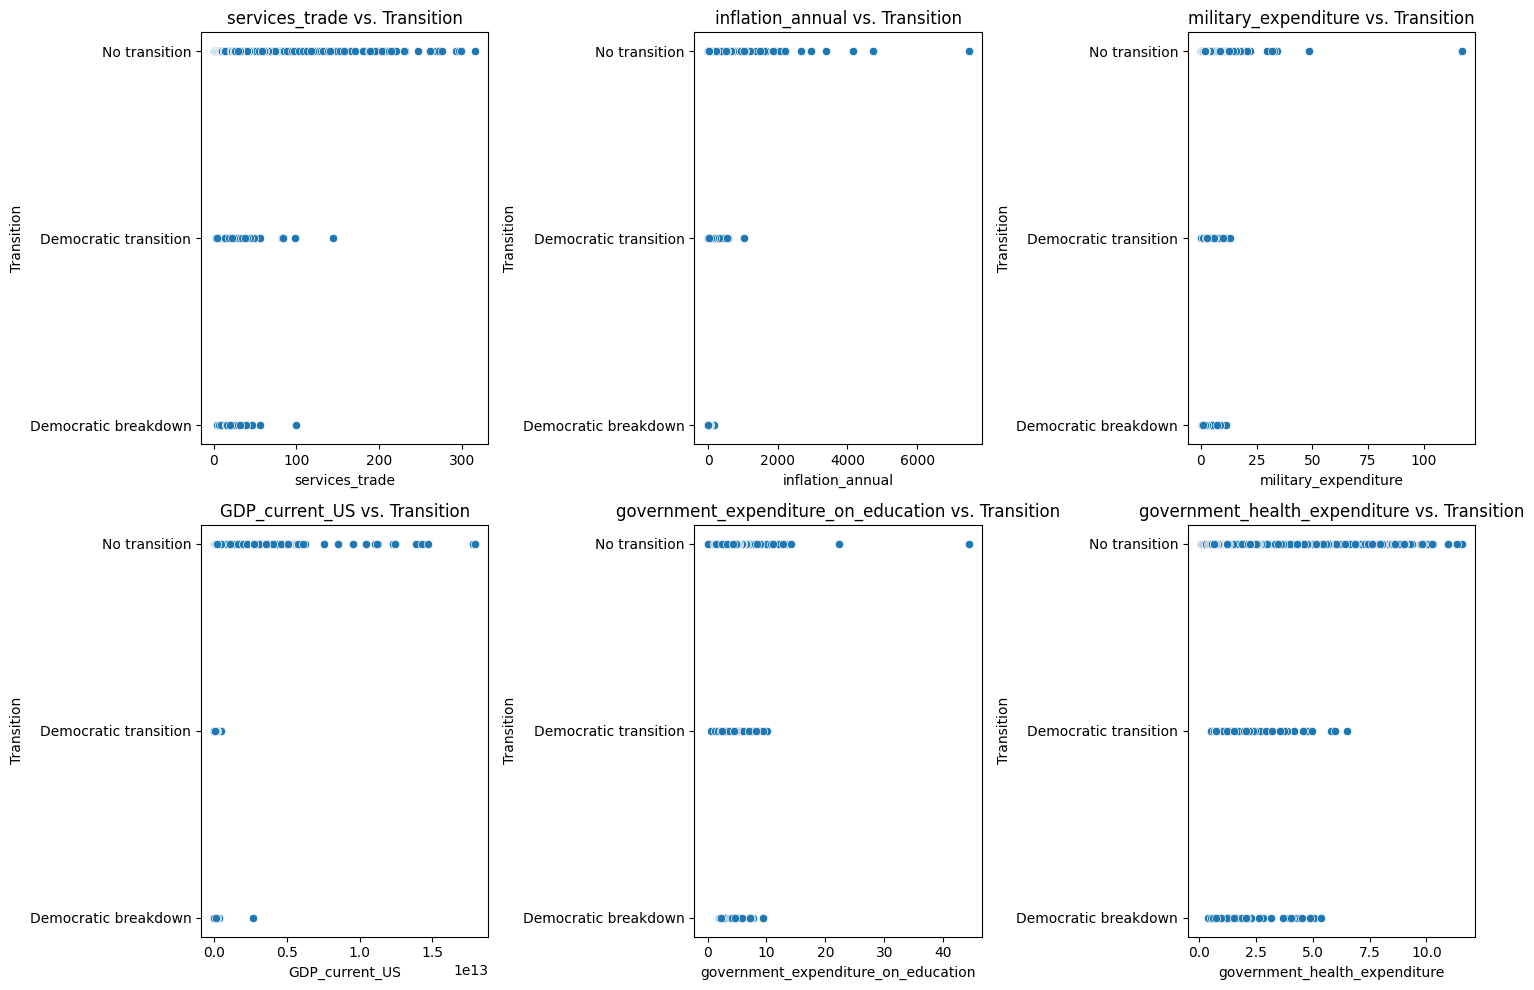

In [57]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(dependent_features, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=feature, y='transition', data=df_imputed)
    plt.title(f'{feature} vs. Transition')
    plt.xlabel(feature)
    plt.ylabel('Transition')
plt.tight_layout()
plt.show()

###Factor Correlation with Governemnt Type via Scatter Plot

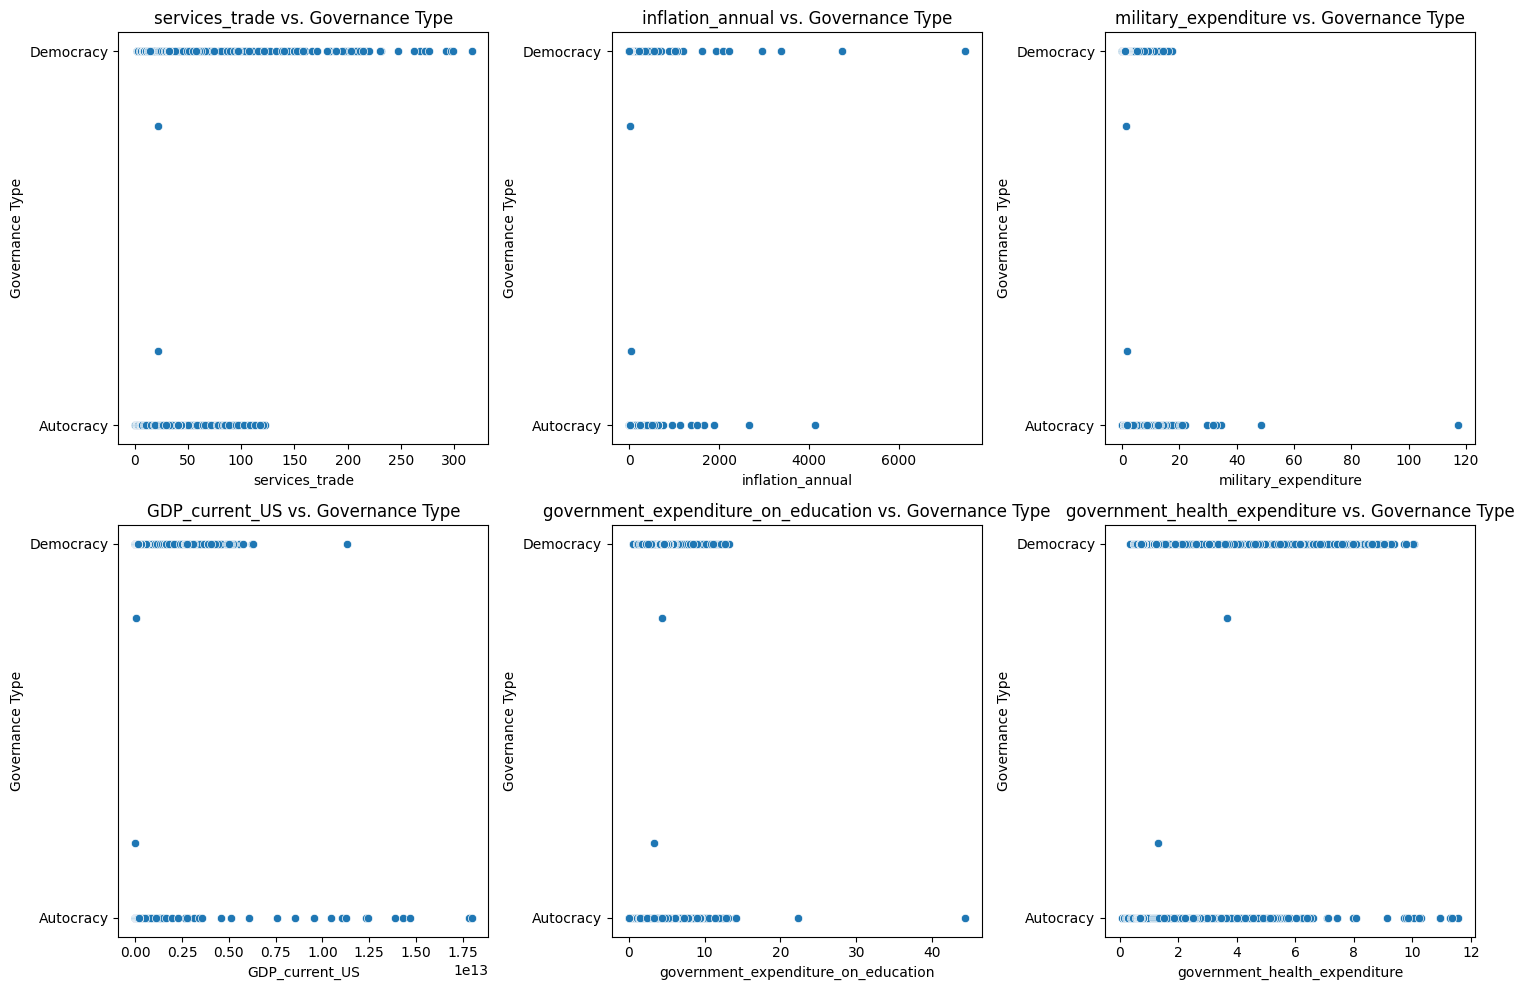

In [58]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(dependent_features, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=feature, y='governance_type', data=df_imputed)
    plt.title(f'{feature} vs. Governance Type')
    plt.xlabel(feature)
    plt.ylabel('Governance Type')
    plt.yticks([0, 1], ['Autocracy', 'Democracy'])
plt.tight_layout()
plt.show()

##Part 6: Insights & Conclusions

To wrap-up things by refering to the primary research questions (i.e. hypothesis) guiding us:


1. **Are economic and social factors combined good indicators of government transitions?**
   - The success of the Random Forest Classifier strongly suggests that the selected economic and social factors serve as effective indicators of government transitions.

2. **How do different dependent variables correlate with government transitions and types?**
   - Upon examining the scatter plots presented earlier, the relationships between individual factors and government transitions/types appear less pronounced. However, the lack of clear correlations highlights the importance of considering combinations of factors in predicting transitions. It is plausible that the collective influence of multiple variables, rather than individual factors alone, contributes to the predictive success of the model.


<i>Yay!</i>
<br>
Thank you for finishing this tutorial! :)
